In [168]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt

In [170]:
file_path = 'train/TRAIN_A.csv'
data = pd.read_csv(file_path)

In [172]:
# 데이터 전처리 함수
def preprocess_data(df, window_size, max_samples=None):
    """
    데이터에서 슬라이딩 윈도우를 생성하여 시계열 데이터로 변환.
    max_samples: 사용할 최대 시계열 데이터 개수.
    """
    normal_data = df[df['anomaly'] == 0]

    sequences = []
    labels = []
    for idx in range(len(normal_data) - window_size):
        window = normal_data.iloc[idx:idx + window_size]
        sequences.append(window.iloc[:, 1:27].values)  # P1 ~ P26 데이터
        labels.append(window.iloc[:, 27:53].values[-1])  # P1_flag ~ P26_flag

    sequences = np.array(sequences)
    labels = np.array(labels)

    if max_samples is not None:
        if len(sequences) > max_samples:
            indices = np.random.choice(len(sequences), max_samples, replace=False)
            sequences = sequences[indices]
            labels = labels[indices]

    return sequences, labels

In [174]:
# 데이터 불러오기 및 준비
window_size = 30
max_samples = 1000  # 사용할 최대 시계열 데이터 개수
sequences, labels = preprocess_data(data, window_size, max_samples)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)  # 다중 라벨링
y_test = torch.tensor(y_test, dtype=torch.float32)  # 다중 라벨링

# DataLoader 설정
batch_size = 64
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 하이퍼파라미터 설정
input_dim = X_train.shape[2]  # P1 ~ P26
hidden_dim = 128
num_layers = 3
learning_rate = 0.0005
epochs = 50

In [176]:
\class LSTMEncoderDecoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(LSTMEncoderDecoder, self).__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.decoder = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        if x.dim() != 3:
            raise ValueError(f"Expected input to be 3D, but got {x.dim()}D.")
        _, (hidden, cell) = self.encoder(x)
        decoder_input = torch.zeros((x.size(0), x.size(1), hidden.size(2)), device=x.device)
        outputs, _ = self.decoder(decoder_input, (hidden, cell))
        reconstruction = self.fc(outputs)
        return reconstruction

In [178]:
# 모델 초기화
model = LSTMEncoderDecoder(input_dim, hidden_dim, num_layers)
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [180]:
# 학습
model.train()
train_losses = []
for epoch in range(epochs):
    epoch_loss = 0
    with tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}") as pbar:
        for batch_x, batch_y in pbar:
            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_x)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            pbar.set_postfix(loss=loss.item())
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch + 1}/{epochs}], Avg Loss: {avg_loss:.4f}")

Epoch 1/50: 100%|█████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.65it/s, loss=4.3e+8]


Epoch [1/50], Avg Loss: 436692553.8462


Epoch 2/50: 100%|████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.54it/s, loss=4.44e+8]


Epoch [2/50], Avg Loss: 437177949.5385


Epoch 3/50: 100%|████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.53it/s, loss=4.45e+8]


Epoch [3/50], Avg Loss: 437207190.1538


Epoch 4/50: 100%|████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.66it/s, loss=4.43e+8]


Epoch [4/50], Avg Loss: 437092290.4615


Epoch 5/50: 100%|█████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.65it/s, loss=4.3e+8]


Epoch [5/50], Avg Loss: 436601715.6923


Epoch 6/50: 100%|████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.54it/s, loss=4.37e+8]


Epoch [6/50], Avg Loss: 436859768.6154


Epoch 7/50: 100%|████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.56it/s, loss=4.39e+8]


Epoch [7/50], Avg Loss: 436923394.4615


Epoch 8/50: 100%|█████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.71it/s, loss=4.3e+8]


Epoch [8/50], Avg Loss: 436562188.3077


Epoch 9/50: 100%|████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.58it/s, loss=4.42e+8]


Epoch [9/50], Avg Loss: 436996418.4615


Epoch 10/50: 100%|███████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.55it/s, loss=4.43e+8]


Epoch [10/50], Avg Loss: 437007603.6923


Epoch 11/50: 100%|████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.75it/s, loss=4.3e+8]


Epoch [11/50], Avg Loss: 436525353.8462


Epoch 12/50: 100%|███████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.75it/s, loss=4.42e+8]


Epoch [12/50], Avg Loss: 436947224.6154


Epoch 13/50: 100%|███████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.52it/s, loss=4.29e+8]


Epoch [13/50], Avg Loss: 436441484.3077


Epoch 14/50: 100%|███████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.83it/s, loss=4.38e+8]


Epoch [14/50], Avg Loss: 436792989.5385


Epoch 15/50: 100%|███████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.65it/s, loss=4.41e+8]


Epoch [15/50], Avg Loss: 436870436.9231


Epoch 16/50: 100%|███████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.58it/s, loss=4.57e+8]


Epoch [16/50], Avg Loss: 437482397.5385


Epoch 17/50: 100%|███████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.56it/s, loss=4.37e+8]


Epoch [17/50], Avg Loss: 436707411.6923


Epoch 18/50: 100%|███████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.67it/s, loss=4.35e+8]


Epoch [18/50], Avg Loss: 436628100.9231


Epoch 19/50: 100%|███████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.58it/s, loss=4.43e+8]


Epoch [19/50], Avg Loss: 436926350.7692


Epoch 20/50: 100%|███████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.49it/s, loss=4.31e+8]


Epoch [20/50], Avg Loss: 436449804.3077


Epoch 21/50: 100%|███████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.74it/s, loss=4.41e+8]


Epoch [21/50], Avg Loss: 436805331.6923


Epoch 22/50: 100%|███████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.73it/s, loss=4.39e+8]


Epoch [22/50], Avg Loss: 436717245.5385


Epoch 23/50: 100%|████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.75it/s, loss=4.4e+8]


Epoch [23/50], Avg Loss: 436765161.8462


Epoch 24/50: 100%|███████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.55it/s, loss=4.36e+8]


Epoch [24/50], Avg Loss: 436573230.7692


Epoch 25/50: 100%|███████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.49it/s, loss=4.32e+8]


Epoch [25/50], Avg Loss: 436415992.6154


Epoch 26/50: 100%|███████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.63it/s, loss=4.45e+8]


Epoch [26/50], Avg Loss: 436898912.0000


Epoch 27/50: 100%|███████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.78it/s, loss=4.34e+8]


Epoch [27/50], Avg Loss: 436492337.2308


Epoch 28/50: 100%|████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.77it/s, loss=4.4e+8]


Epoch [28/50], Avg Loss: 436705718.1538


Epoch 29/50: 100%|███████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.63it/s, loss=4.32e+8]


Epoch [29/50], Avg Loss: 436358850.4615


Epoch 30/50: 100%|███████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.40it/s, loss=4.35e+8]


Epoch [30/50], Avg Loss: 436496273.2308


Epoch 31/50: 100%|███████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.63it/s, loss=4.39e+8]


Epoch [31/50], Avg Loss: 436618503.3846


Epoch 32/50: 100%|███████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.60it/s, loss=4.32e+8]


Epoch [32/50], Avg Loss: 436356531.6923


Epoch 33/50: 100%|███████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.59it/s, loss=4.23e+8]


Epoch [33/50], Avg Loss: 435970102.1538


Epoch 34/50: 100%|███████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.62it/s, loss=4.45e+8]


Epoch [34/50], Avg Loss: 436833252.9231


Epoch 35/50: 100%|███████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.78it/s, loss=4.36e+8]


Epoch [35/50], Avg Loss: 436458707.6923


Epoch 36/50: 100%|███████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.63it/s, loss=4.36e+8]


Epoch [36/50], Avg Loss: 436465203.6923


Epoch 37/50: 100%|███████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.48it/s, loss=4.24e+8]


Epoch [37/50], Avg Loss: 435986363.0769


Epoch 38/50: 100%|███████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.63it/s, loss=4.25e+8]


Epoch [38/50], Avg Loss: 436014865.2308


Epoch 39/50: 100%|███████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.60it/s, loss=4.33e+8]


Epoch [39/50], Avg Loss: 436307645.5385


Epoch 40/50: 100%|███████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.65it/s, loss=4.48e+8]


Epoch [40/50], Avg Loss: 436878003.6923


Epoch 41/50: 100%|███████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.85it/s, loss=4.43e+8]


Epoch [41/50], Avg Loss: 436675532.3077


Epoch 42/50: 100%|████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.46it/s, loss=4.2e+8]


Epoch [42/50], Avg Loss: 435757878.1538


Epoch 43/50: 100%|███████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.51it/s, loss=4.42e+8]


Epoch [43/50], Avg Loss: 436601208.6154


Epoch 44/50: 100%|████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.67it/s, loss=4.4e+8]


Epoch [44/50], Avg Loss: 436513949.5385


Epoch 45/50: 100%|███████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.59it/s, loss=4.45e+8]


Epoch [45/50], Avg Loss: 436681902.7692


Epoch 46/50: 100%|███████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.70it/s, loss=4.43e+8]


Epoch [46/50], Avg Loss: 436608873.8462


Epoch 47/50: 100%|███████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.72it/s, loss=4.39e+8]


Epoch [47/50], Avg Loss: 436455318.1538


Epoch 48/50: 100%|███████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.78it/s, loss=4.29e+8]


Epoch [48/50], Avg Loss: 436039138.4615


Epoch 49/50: 100%|███████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.63it/s, loss=4.41e+8]


Epoch [49/50], Avg Loss: 436488302.7692


Epoch 50/50: 100%|███████████████████████████████████████████████████████| 13/13 [00:09<00:00,  1.36it/s, loss=4.42e+8]

Epoch [50/50], Avg Loss: 436528642.4615


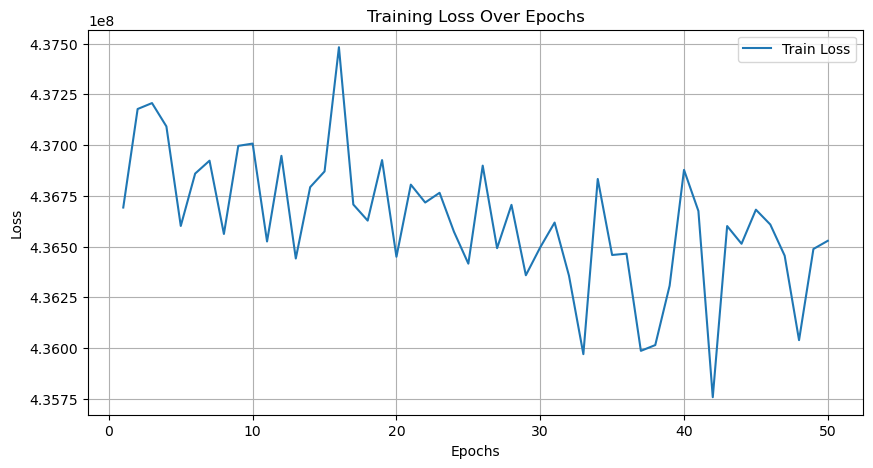

In [182]:
# 학습 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label="Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

In [200]:
# 이상 점수 계산 및 평가
model.eval()
def evaluate_model_on_anomalies(model, anomaly_data, window_size):
    """
    모델이 정상 데이터로 학습한 후, 이상 데이터의 재구성 오류를 평가.
    """
    anomaly_sequences = []
    true_flags = []
    for idx in range(len(anomaly_data) - window_size):
        window = anomaly_data.iloc[idx:idx + window_size]
        anomaly_sequences.append(window.iloc[:, 1:27].values)  # P1 ~ P26 데이터
        true_flags.append(window.iloc[:, 27:53].values[-1])  # P1_flag ~ P26_flag

    anomaly_sequences = np.array(anomaly_sequences)
    anomaly_sequences = torch.tensor(anomaly_sequences, dtype=torch.float32)
    true_flags = torch.tensor(np.array(true_flags), dtype=torch.float32)

    if anomaly_sequences.dim() != 3:
        anomaly_sequences = anomaly_sequences.unsqueeze(1) if anomaly_sequences.dim() == 2 else anomaly_sequences.unsqueeze(0).unsqueeze(0)

    with torch.no_grad():
        reconstruction = model(anomaly_sequences)
        reconstruction_error = torch.mean((anomaly_sequences - reconstruction) ** 2, dim=(1, 2))

    predicted_flags = (reconstruction_error.unsqueeze(-1) > reconstruction_error.mean()).float()
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_flags.numpy().reshape(-1), predicted_flags.numpy().reshape(-1),
        average='binary', zero_division=0
    )
    return precision, recall, f1

In [202]:
# 이상 데이터 평가
test_anomaly_data = data[data['anomaly'] == 1]
precision, recall, f1 = evaluate_model_on_anomalies(model, test_anomaly_data, window_size)
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

RuntimeError: input.size(-1) must be equal to input_size. Expected 26, got 0